In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/PATIENTS.csv.gz ./

In [3]:
!cp drive/MyDrive/ICUSTAYS.csv.gz ./

In [4]:
!cp drive/MyDrive/ADMISSIONS.csv.gz ./

In [5]:
!cp drive/MyDrive/DIAGNOSES_ICD.csv.gz ./

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import datetime as dt

In [34]:
ICUSTAYS = pd.read_csv('ICUSTAYS.csv.gz',compression='gzip')
PATIENTS = pd.read_csv('PATIENTS.csv.gz',compression='gzip')
DIAGNOSES_ICD = pd.read_csv('DIAGNOSES_ICD.csv.gz',compression='gzip')
ADMISSIONS = pd.read_csv('ADMISSIONS.csv.gz',compression='gzip')

In [8]:
# Convert to datetime format
ADMISSIONS['ADMITTIME'] = pd.to_datetime(ADMISSIONS['ADMITTIME'])
ADMISSIONS['DISCHTIME'] = pd.to_datetime(ADMISSIONS['DISCHTIME'])

In [9]:
# Find the difference between the admission and discharge to find the length of stay
ADMISSIONS['LOS'] = (ADMISSIONS['DISCHTIME']-ADMISSIONS['ADMITTIME'])

In [ ]:
# Drop the negative values in the length of stay coloumn
ADMISSIONS = ADMISSIONS[ADMISSIONS['LOS'] >= pd.Timedelta(0)]

# Drop the rows that have a value for death
ADMISSIONS = ADMISSIONS[ADMISSIONS['DEATHTIME'].isna()]

<ipython-input-11-41fe8fc66117>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADMISSIONS['LOSdays'] = ADMISSIONS['LOS'].dt.days


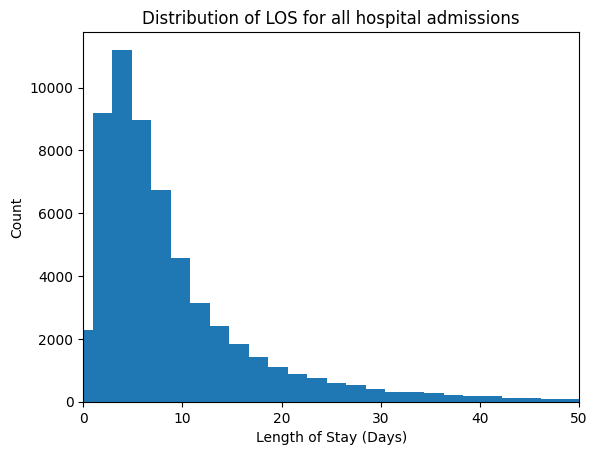

In [10]:
# Create a histogram of Length of Stay
# Create one variable with the none na values in the LOS column
los_values = ADMISSIONS['LOS'].dropna()
# Convert timedelta64[ns] to total days for plotting
los_values_days = los_values.dt.days
# Create histogram
plt.hist(los_values_days, bins=150)
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Count')
plt.title('Distribution of LOS for all hospital admissions')
plt.xlim(0, 50)
plt.show()


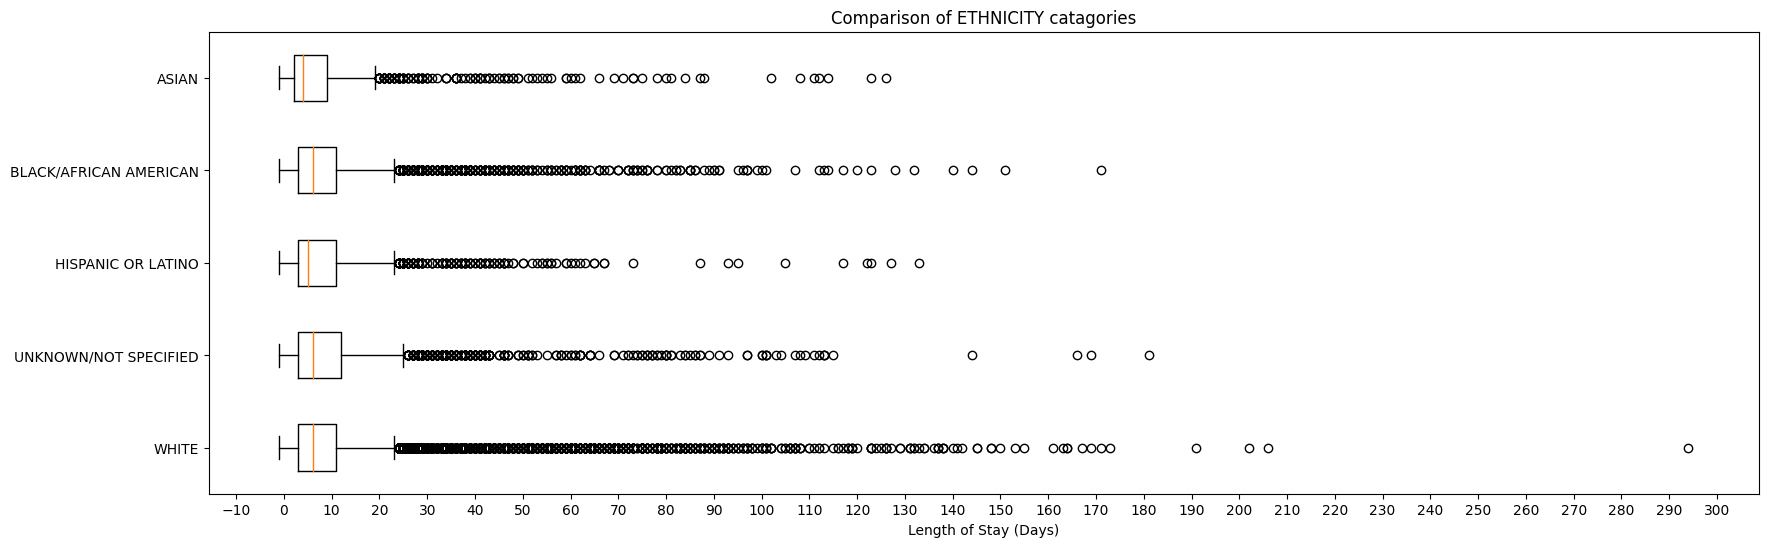

In [ ]:
from matplotlib.ticker import MultipleLocator
# Create a box and whisker chart grouped by ethnicity
# Choose the ethnicities
ethnicities = ['WHITE', 'UNKNOWN/NOT SPECIFIED', 'HISPANIC OR LATINO','BLACK/AFRICAN AMERICAN','ASIAN']
# Drop the na values in the 'LOS' column
admissions_los = ADMISSIONS.dropna(subset=['LOS'])
admissions_los['LOS'] = admissions_los['LOS'].dt.days
# Filter the DataFrame for the desired ethnicities
adm_filtered = admissions_los[admissions_los['ETHNICITY'].isin(ethnicities)]
# Set the size of the window
plt.figure(figsize=(20, 6))
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
# Create the chart
plt.boxplot([adm_filtered[adm_filtered['ETHNICITY'] == ethnicity]['LOS'] for ethnicity in ethnicities], labels=ethnicities, vert=False)
plt.xlabel('Length of Stay (Days)')
plt.title('Comparison of ETHNICITY catagories')

plt.show()

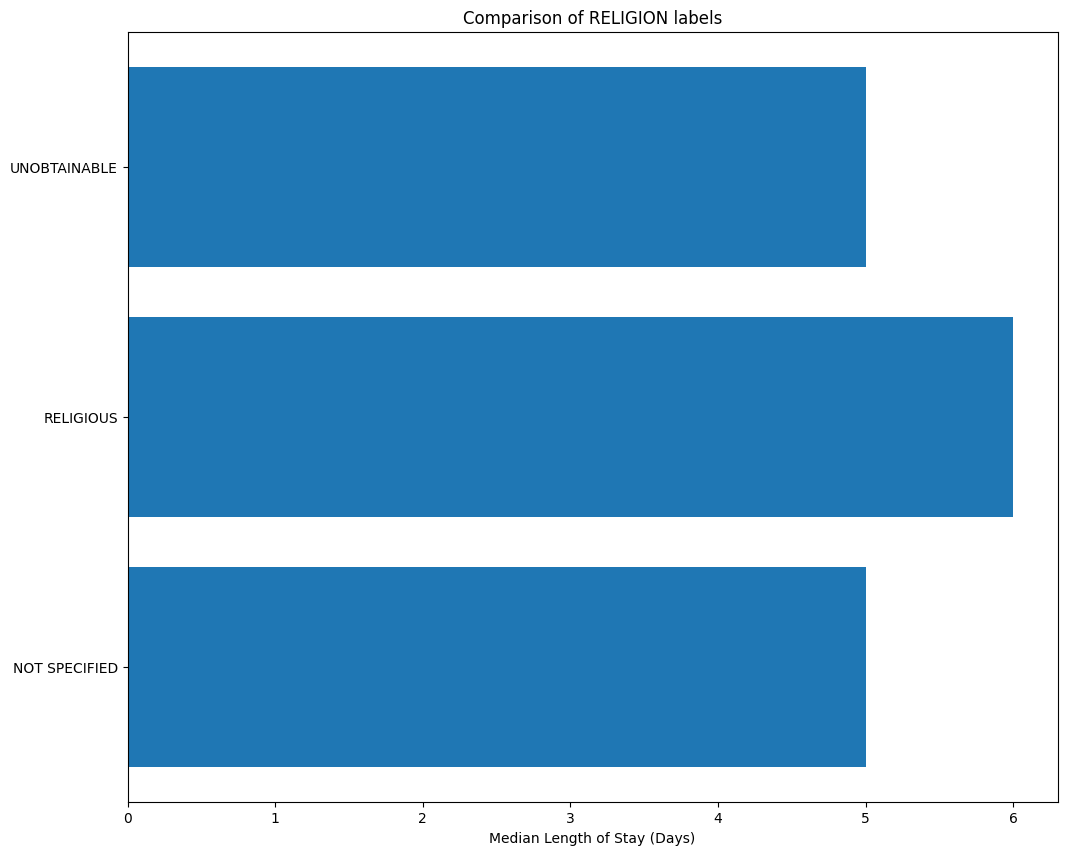

In [ ]:
# Create the bar chart
# Group into 3 groups: unobtainable, not specified and religious.
# All the religions that are not unobtainable or not specified will be religious
nonreligious = ['UNOBTAINABLE', 'NOT SPECIFIED']
admissions_los['RELIGION'] = admissions_los['RELIGION'].apply(lambda x: x if x in nonreligious else 'RELIGIOUS')
# Find the median of the length of stay for each group in the religion
median_rel = admissions_los.groupby('RELIGION')['LOS'].median().reset_index()
# Create the bar chart
plt.figure(figsize=(12, 10))
plt.barh(median_rel['RELIGION'],median_rel['LOS'])
# Set labels and title
plt.xlabel('Median Length of Stay (Days)')
plt.title('Comparison of RELIGION labels')

plt.show()


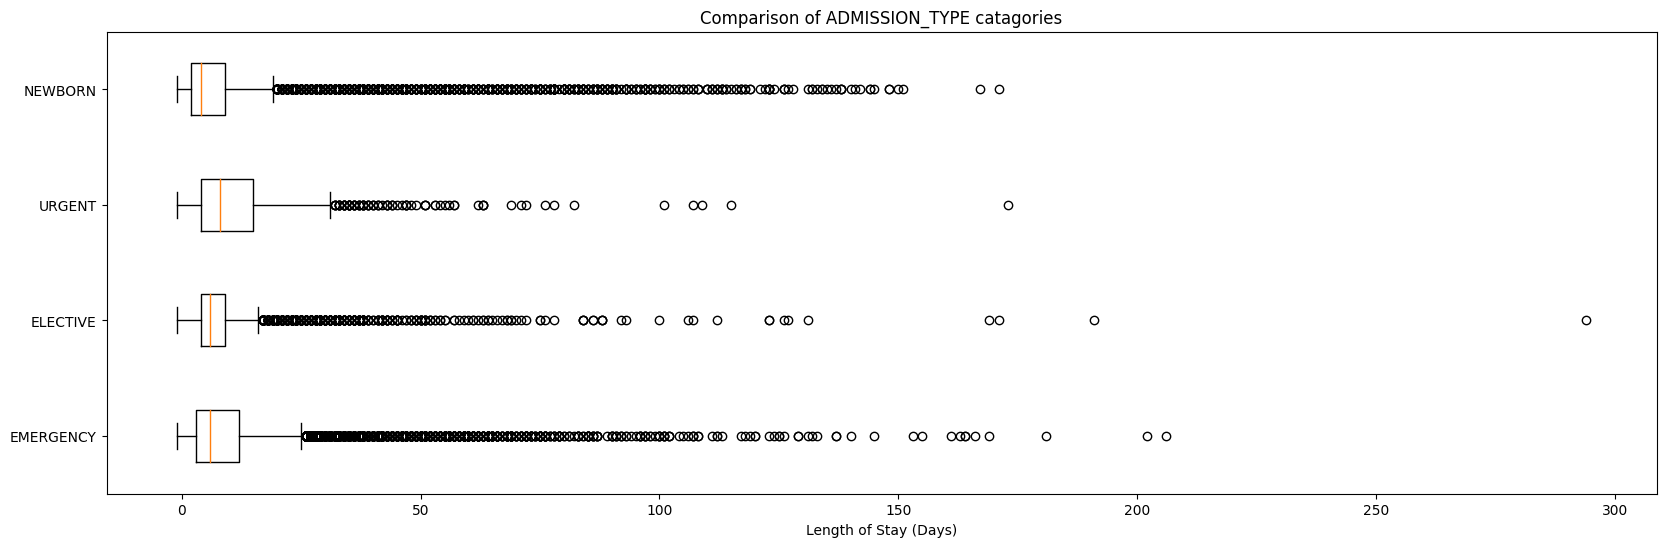

In [ ]:
# Create a box and whisker chart grouped by admission type
# Choose the ethnicities
admissiontype = ['EMERGENCY', 'ELECTIVE', 'URGENT','NEWBORN']
# Filter the DataFrame for the desired ethnicities
adm_filtered = admissions_los[admissions_los['ADMISSION_TYPE'].isin(admissiontype)]
# Set the size of the window
plt.figure(figsize=(20, 6))
# Create the chart
plt.boxplot([adm_filtered[adm_filtered['ADMISSION_TYPE'] == admissiontype]['LOS'] for admissiontype in admissiontype], labels=admissiontype, vert=False)
# Set labels and title
plt.xlabel('Length of Stay (Days)')
plt.title('Comparison of ADMISSION_TYPE catagories')

plt.show()

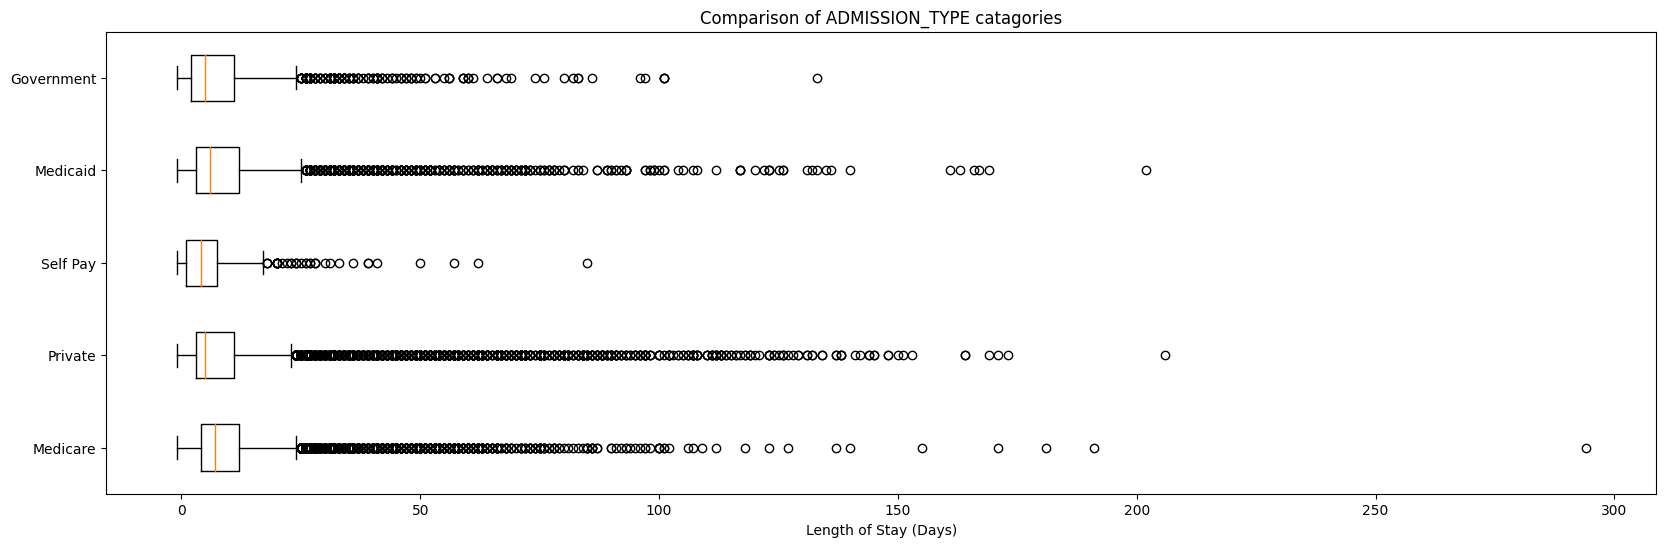

In [ ]:
# Create a box and whisker chart grouped by pay insurance
# Choose the ethnicities
insurances = ['Medicare', 'Private', 'Self Pay','Medicaid','Government']
# Filter the DataFrame for the desired ethnicities
adm_filtered = admissions_los[admissions_los['INSURANCE'].isin(insurances)]
# Set the size of the window
plt.figure(figsize=(20, 6))
# Create the chart
plt.boxplot([adm_filtered[adm_filtered['INSURANCE'] == insurances]['LOS'] for insurances in insurances], labels=insurances, vert=False)
# Set labels and title
plt.xlabel('Length of Stay (Days)')
plt.title('Comparison of ADMISSION_TYPE catagories')
plt.show()

In [12]:
# Merge the admissions and patients data sets together
merged_df = pd.merge(ADMISSIONS, PATIENTS, on='SUBJECT_ID')
# Only use the first admit date if any patient had more than one
#merged_df[['SUBJECT_ID2','ADMITTIME2']] = merged_df[['SUBJECT_ID','ADMITTIME']].groupby('SUBJECT_ID').min

In [13]:
# Format the Dob and admit time to the year
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'])
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'])
# Subtract to find the age
merged_df['age'] = ((merged_df['ADMITTIME'].dt.year).subtract(merged_df['DOB'].dt.year))
# Rename all the ages 89 and over to 90
merged_df.loc[merged_df['age']>90,'age'] = 90
merged_df.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,LOS,LOSdays,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,age
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1 days 03:28:00,1,19,F,2131-05-07,NaN,NaN,NaN,0,65
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,5 days 11:55:00,5,20,M,2082-07-17,NaN,NaN,NaN,0,71
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,6 days 18:26:00,6,20,M,2082-07-17,NaN,NaN,NaN,0,75
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,2 days 20:34:00,2,21,M,2100-05-31,NaN,NaN,NaN,0,39
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,3 days 12:49:00,3,22,M,2101-11-21,NaN,NaN,NaN,0,59


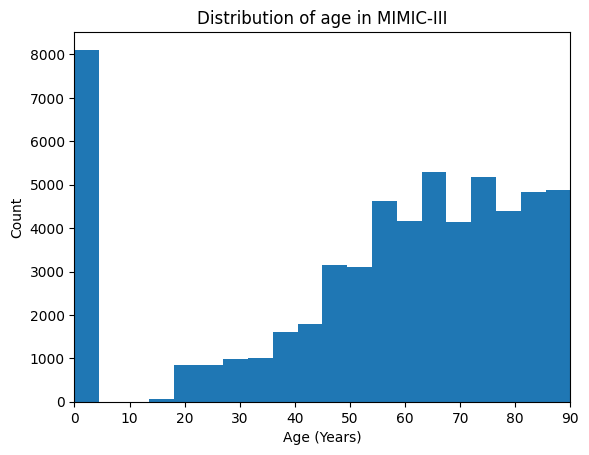

In [14]:
# Create a histogram
# Create one variable with the none na values in the LOS column
age_values = merged_df['age'].dropna()
# age_values = age_values.dt.year
# Create histogram
plt.hist(age_values, bins=20)
plt.xlabel('Age (Years)')
plt.ylabel('Count')
plt.title('Distribution of age in MIMIC-III')
plt.xlim(0, 90)
plt.show()

In [15]:
# Create different age catagories
merged_df.loc[merged_df['age']<=1,'age_catagories'] = 'newborn'
merged_df.loc[(merged_df['age']>1)&(merged_df['age']<=40),'age_catagories'] = 'young_adult'
merged_df.loc[(merged_df['age']>40)&(merged_df['age']<=64),'age_catagories'] = 'middle_age'
merged_df.loc[(merged_df['age']>64)&(merged_df['age']<=90),'age_catagories'] = 'senior'

In [ ]:
# Add a coloumn of the length of stay in days
ADMISSIONS['LOSdays'] = ADMISSIONS['LOS'].dt.days
merged_df.plot.scatter('age','LOSdays')
plt.title('Age versus LOS')
plt.show

In [50]:
DIAGNOSES_ICD['simple_ICD'] = DIAGNOSES_ICD['ICD9_CODE'].astype(str).str[:3]
DIAGNOSES_ICD['group'] = pd.to_numeric(DIAGNOSES_ICD['simple_ICD'], errors='coerce')
# Drop NaN values or fill them with a default value
#df = df.dropna()  # Drop rows with NaN values
DIAGNOSES_ICD['group'] = DIAGNOSES_ICD['group'].fillna(0).astype(int)

In [59]:
#DIAGNOSES_ICD['group'] = DIAGNOSES_ICD['simple_ICD'].astype(int)
# Create 17 different ICD catagories
#DIAGNOSES_ICD.loc[DIAGNOSES_ICD['group']==0,'group'] = 'external causes of injury and supplemental classification'
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>0)&(DIAGNOSES_ICD['group']<=139),'grouped']  = 1#'infectious and parasitic diseases'
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>139)&(DIAGNOSES_ICD['group']<=239),'grouped'] = 2#'neoplasms'
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>239)&(DIAGNOSES_ICD['group']<=279),'grouped'] = 17#'endocrine, nutritional and metabolic diseases, and immunity disorders
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>279)&(DIAGNOSES_ICD['group']<=289),'grouped'] = 3#'endocrine, nutritional and metabolic diseases, and immunity disorders'
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>289)&(DIAGNOSES_ICD['group']<=319),'grouped'] = 4#'mental disorders'
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>319)&(DIAGNOSES_ICD['group']<=389),'grouped'] = 5#'diseases of the nervous system and sense organ'
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>389)&(DIAGNOSES_ICD['group']<=459),'grouped'] = 6#diseases of the circulatory system
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>459)&(DIAGNOSES_ICD['group']<=519),'grouped'] = 7#diseases of the respiratory system
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>519)&(DIAGNOSES_ICD['group']<=579),'grouped'] = 8#diseases of the digestive system
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>579)&(DIAGNOSES_ICD['group']<=629),'grouped'] = 9#diseases of the genitourinary system
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>629)&(DIAGNOSES_ICD['group']<=679),'grouped'] = 10#complications of pregnancy, childbirth, and the puerperium
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>679)&(DIAGNOSES_ICD['group']<=709),'grouped'] = 11#diseases of the skin and subcutaneous tissue
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>709)&(DIAGNOSES_ICD['group']<=739),'grouped'] = 12#diseases of the musculoskeletal system and connective tissue
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>739)&(DIAGNOSES_ICD['group']<=759),'grouped'] = 13#congenital anomalies
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>759)&(DIAGNOSES_ICD['group']<=779),'grouped'] = 14#certain conditions originating in the perinatal period
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>779)&(DIAGNOSES_ICD['group']<=799),'grouped'] = 15#symptoms, signs, and ill-defined conditions
DIAGNOSES_ICD.loc[(DIAGNOSES_ICD['group']>799)&(DIAGNOSES_ICD['group']<=999),'grouped'] = 16#'injury and poisoning'
DIAGNOSES_ICD['grouped'] = DIAGNOSES_ICD['grouped'].fillna(0).astype(int)

In [60]:
# Create titles for the groups

DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==0,'name'] = 'external causes of injury and supplemental classification'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==1,'name'] = 'infectious and parasitic diseases'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==2,'name'] = 'neoplasms'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==3,'name'] = 'endocrine, nutritional and metabolic diseases, and immunity disorders'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==4,'name'] = 'mental disorders'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==5,'name'] ='diseases of the nervous system and sense organ'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==6,'name'] = 'diseases of the circulatory system'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==7,'name']  = 'diseases of the respiratory system'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==8,'name'] = 'diseases of the digestive system'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==9,'name']  = 'diseases of the genitourinary system'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==10,'name'] = 'complications of pregnancy, childbirth, and the puerperium'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==11,'name'] = 'diseases of the skin and subcutaneous tissue'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==12,'name'] = 'diseases of the musculoskeletal system and connective tissue'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==13,'name'] = 'congenital anomalies'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==14,'name'] = 'certain conditions originating in the perinatal period'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==15,'name'] = 'symptoms, signs, and ill-defined conditions'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==16,'name'] = 'injury and poisoning'
DIAGNOSES_ICD.loc[DIAGNOSES_ICD['grouped']==17,'name'] = 'endocrine, nutritional and metabolic diseases, and immunity disorders'

List of ICD-9 codes 001–139: infectious and parasitic diseases
List of ICD-9 codes 140–239: neoplasms
List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
List of ICD-9 codes 290–319: mental disorders
List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
List of ICD-9 codes 390–459: diseases of the circulatory system
List of ICD-9 codes 460–519: diseases of the respiratory system
List of ICD-9 codes 520–579: diseases of the digestive system
List of ICD-9 codes 580–629: diseases of the genitourinary system
List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
List of ICD-9 codes 740–759: congenital anomalies
List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
List of ICD-9 codes 800–999: injury and poisoning
List of ICD-9 codes E and V codes: external causes of injury and supplemental classification

In [73]:
# Create a grouping of ICD9 codes types for each admission
# orders the addmission id
DIAGNOSES_ICD['diagnosis_order'] = DIAGNOSES_ICD.groupby('HADM_ID').cumcount() + 1
# Pivot the DataFrame to have each diagnosis in its own column
pivot_df = DIAGNOSES_ICD.pivot_table(index='HADM_ID', columns='name', values='grouped', aggfunc='count')
# Reset the index to flatten the DataFrame
pivot_df.reset_index(inplace=True)
# Fill the na values with 0
pivot_df.fillna(0, inplace=True)
# Now pivot_df contains the diagnoses for each admission_id in separate columns

In [96]:
# merge the new pivot table with the rest of the data set
merged_df2 = pd.merge(merged_df, pivot_df, on='HADM_ID', how='left')

In [133]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [126]:
# Create dummy variables for the following columns:
dummies = pd.get_dummies(data=merged_df2, columns=['ADMISSION_TYPE', 'INSURANCE','RELIGION','ETHNICITY','age_catagories','MARITAL_STATUS'])

In [145]:
# Only use the columns with numerical values
numerical_cols = dummies.select_dtypes(include=['float64', 'int64']).columns
features = dummies[numerical_cols]
# Drop the target variable since it will be for the X value
features = features.drop(columns='LOSdays')
LOS = dummies['LOSdays']
# Split into test-training data
X_train, X_test, y_train, y_test = train_test_split(features, LOS, test_size = .20)

In [148]:
# Created a GradientBoostingRegressor using the specified values.
# Not sure why my results are not as good
# Used the defaults specified
gb_regressor = GradientBoostingRegressor(n_estimators=200, max_depth=4)
# Fit it to our X and y training info
gb_regressor.fit(X_train, y_train)
# Predict the results using the X test
y_pred = gb_regressor.predict(X_test)
# Conclude the accuracy of the model by comparing with the y test
y_pred = gb_regressor.predict(X_test)
# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

R2 score: 0.4082655554976463


In [136]:
# Check which were the most signifigant variables on LOS
feature_importances = gb_regressor.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importances
for i in sorted_indices:
    print(f"{X_train.columns[i]}: {feature_importances[i]}")

certain conditions originating in the perinatal period: 0.3283569998611252
injury and poisoning: 0.1048450131112765
diseases of the respiratory system: 0.10415285255023404
infectious and parasitic diseases: 0.0857177175534214
diseases of the nervous system and sense organ: 0.0790018533773001
diseases of the digestive system: 0.06479090483913112
diseases of the skin and subcutaneous tissue: 0.032053383976335795
external causes of injury and supplemental classification: 0.020903062159597224
congenital anomalies: 0.019890959277814816
age: 0.019256488312183448
diseases of the genitourinary system: 0.01735303815085682
diseases of the circulatory system: 0.01690979613552232
SUBJECT_ID: 0.015421485074288642
ROW_ID_x: 0.014191527250420494
ROW_ID_y: 0.013750753782735464
HOSPITAL_EXPIRE_FLAG: 0.012177361972247325
endocrine, nutritional and metabolic diseases, and immunity disorders: 0.012126859466822114
symptoms, signs, and ill-defined conditions: 0.01111721669690576
HADM_ID: 0.01066466231050334

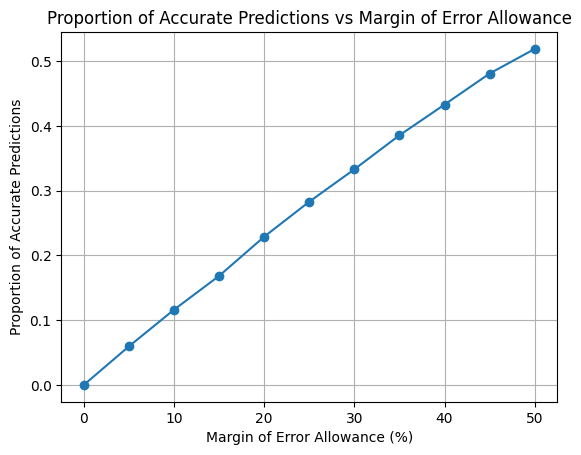

In [137]:
# Got this code online

# Define a range of margin of error allowances
margin_of_error_range = np.arange(0, 51, 5)  # From 0 to 50% margin of error, with a step size of 5%

# Initialize lists to store proportions of accurate predictions
proportions_accurate = []

# Calculate the proportion of accurate predictions for each margin of error allowance
for margin_of_error in margin_of_error_range:
    lower_bound = y_test * (1 - margin_of_error / 100)
    upper_bound = y_test * (1 + margin_of_error / 100)
    within_range = ((y_pred >= lower_bound) & (y_pred <= upper_bound)).sum()
    proportion_accurate = within_range / len(y_test)
    proportions_accurate.append(proportion_accurate)

# Plot the proportion of accurate predictions against the margin of error allowances
plt.plot(margin_of_error_range, proportions_accurate, marker='o')
plt.xlabel('Margin of Error Allowance (%)')
plt.ylabel('Proportion of Accurate Predictions')
plt.title('Proportion of Accurate Predictions vs Margin of Error Allowance')
plt.grid(True)
plt.show()
